In [39]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import rasterio
import rasterio.features
import shapely
from shapely.geometry import box, Polygon
from tqdm import tqdm

In [40]:
tqdm.pandas()

# 1. Functions

In [41]:
def viz(cbg_sj, cbg_footprints, column, fp, save=True):

    # plot shapefile using the inferred area as the label for each CBG
    plt.clf()
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca()
    ax.set_aspect('equal')
    cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
    cbg_footprints.loc[cbg_footprints[column] == 1].plot(column='area', zorder=2, ax=ax, legend=True)
    if save:
        plt.savefig(os.path.join(fp, 'Visualizations', 'plot_{}.png'.format(column)))
    else:
        plt.show()

In [42]:
def get_footprint_gpd(mask, file_name, size):
    """
    Converts predictions from np.array to shapely polygons
    :param mask: (np.array) Footprint mask from which to generate the polygons
    :param file_name: (str) Name of the TIF file 
    :param size: (int) Resolution size [512, 1024]
    :return: (gpd.GeoDataFrame)
    """

    with rasterio.open(os.path.join(TIF_FP, f'{file_name}.tif')) as ds:
        t = ds.transform

    # Adjust for resolution
    if size == 512:
        factor = 1
    elif size == 1024:
        factor = 2
    elif size == 512 * 4:
        factor = 4 # CHECK
    else:
        raise NotImplemented('[ERROR] GPD Footprint --- Check resolution')

    shapes = rasterio.features.shapes(mask, connectivity=4)
    polygons = [shapely.geometry.Polygon(shape[0]["coordinates"][0]) for shape in shapes if shape[1] == 1]
    polygons = [shapely.affinity.affine_transform(geom, [t.a / factor, t.b, t.d, t.e / factor, t.xoff, t.yoff]) for geom
                in polygons]
    buildings = gpd.GeoDataFrame(geometry=polygons, crs='EPSG:26910')
    buildings = buildings.to_crs('EPSG:4326')
    return buildings

In [43]:
def collect_inferences(inferences_dir, size):
    inference_files = glob.glob(os.path.join(inferences_dir, '*.npy'))
    building_footprints = gpd.GeoDataFrame()
    for inference_file in tqdm(inference_files):
        file_name = inference_file.split(os.path.sep)[-1].replace('.npy', '')
        mask = np.load(inference_file)
        tile_buildings = get_footprint_gpd(mask, file_name, size)
        tile_buildings['tile'] = inference_file
        building_footprints = pd.concat([building_footprints, tile_buildings])

    return building_footprints

In [44]:
def assign_cbgs(building_footprints, cbg_sj):
    # Assign buildings to San Jose CBGs
    building_footprints = building_footprints.to_crs(cbg_sj.crs)
    building_footprints_cbg = gpd.sjoin(
        cbg_sj[['GEOID', 'geometry']], building_footprints, 
        how='right', predicate='contains')

    # Drop buildings outside of San Jose
    building_footprints_cbg = building_footprints_cbg.dropna(axis=0, subset=['GEOID'])
    return building_footprints_cbg

In [123]:
def process_buildings(building_footprints, zoning, sj_crs, verbose=True):
    # Merge buildings to connect buildings on tile edges
    if verbose:
        print('[INFO] Processing: Merging buildings on tile edges')
    geoms = building_footprints.geometry.unary_union
    building_footprints = gpd.GeoDataFrame(geometry=[geoms], crs='EPSG:4326')
    building_footprints = building_footprints.explode(index_parts=True).reset_index(drop=True)

    # Separate buildings
    if verbose:
        print('[INFO] Processing: Separating buildings')
    building_footprints = building_footprints.to_crs(crs=3857)
    if verbose:
        building_footprints.geometry = building_footprints.geometry.progress_apply(lambda x: x.buffer(-2))
    else:
        building_footprints.geometry = building_footprints.geometry.buffer(-2)
    building_footprints = building_footprints.explode(index_parts=False)
    if verbose:
        building_footprints.geometry = building_footprints.geometry.progress_apply(lambda x: x.buffer(2))
    else:
        building_footprints.geometry = building_footprints.geometry.buffer(2)
    building_footprints = building_footprints.to_crs(sj_crs)

    # Remove predictions on roads
    if verbose:
        print('[INFO] Processing: Removing predictions on roads')
    if len(building_footprints) > 0:
        building_footprints = gpd.clip(building_footprints, zoning)

    return building_footprints

In [46]:
def compute_area(building_footprints, small_upper_threshold, large_upper_threshold, sj_crs):
    # Compute building area
    building_footprints = building_footprints.to_crs(crs=3857)
    building_footprints['area'] = building_footprints.area
    
    # Filter for buildings that are too small or too large
    building_footprints = building_footprints.loc[building_footprints['area'] > 15]
    if large_upper_threshold:
        building_footprints = building_footprints.loc[building_footprints['area'] < large_upper_threshold]

    # Define small/large buildings
    # add up sqft/m^2 for just small buildings, or for both large and small buildings
    building_footprints['small'] = building_footprints['area'] < small_upper_threshold
    building_footprints['large'] = 1 - building_footprints['small']
    
    building_footprints = building_footprints.to_crs(sj_crs)
    return building_footprints

In [47]:
def main(cbg_sj, zoning, inferences_dir, size, small_threshold, large_threshold, fp):

    # 1) Loop over each tile to convert the inference np.array to gpd
    # This step outputs a gpd of building footprints: building_footprints
    collected_footprints_file = os.path.join(fp, 'building_inferences')
    if not os.path.exists(collected_footprints_file):
        print('[INFO] Collecting building footprints')
        building_footprints = collect_inferences(inferences_dir, size)
        building_footprints.to_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))

    # 2) Vectorized processing of buildings at the cbg level using the gpd output from step 3
    #     - combine tile edge buildings
    #     - road filtering
    #     - building separation
    processed_footprints_file = os.path.join(fp, 'building_processed')
    if not os.path.exists(processed_footprints_file):
        print('[INFO] Loading building footprints')
        building_footprints = gpd.read_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        print('[INFO] Processing building footprints')
        building_footprints = process_buildings(building_footprints, zoning, cbg_sj.crs)
        building_footprints.to_file(processed_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))

    # 3) assign buildings to CBGs
    final_footprints_file = os.path.join(fp, 'building_footprints_final')
    if not os.path.exists(final_footprints_file):
        print('[INFO] Loading processed buildings')
        building_footprints = gpd.read_file(processed_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        print('[INFO] Assigning buildings to CBGs') 
        building_footprints = assign_cbgs(building_footprints, cbg_sj)

        # 4) Call gpd.geometry.area on the output from 4) using groupby with the cbg column
        # to get cbg-level area computations for large and small buildings
        print('[INFO] Computing building area')
        building_footprints = compute_area(building_footprints, small_threshold, large_threshold, cbg_sj.crs)
        
        print('[INFO] Generating CBG-level GeoDataFrame')
        cbg_footprints = building_footprints.groupby(['GEOID', 'small', 'large'])[['area']].sum().reset_index()

        # Add back geometry data to CBGs
        cbg_footprints = pd.merge(cbg_footprints, cbg_sj[['GEOID', 'geometry']], how='left', on='GEOID')

        print('[INFO] Exporting building and CBG shapefiles')
        building_footprints.to_file(final_footprints_file)
        cbg_footprints.to_file(os.path.join(fp, 'cbg_inferences'))
    else:
        print('[INFO] Loading building and CBG shapefiles')
        building_footprints = gpd.read_file(final_footprints_file)
        cbg_footprints = gpd.read_file(os.path.join(fp, 'cbg_inferences'))

        # 5) Visualize
        viz(cbg_sj, cbg_footprints, 'small', fp)
        viz(cbg_sj, cbg_footprints, 'large', fp)

    return building_footprints, cbg_footprints

In [75]:
def main_split(cbg_sj, zoning, inferences_dir, size, small_threshold, large_threshold, fp):

    # 1) Loop over each tile to convert the inference np.array to gpd
    # This step outputs a gpd of building footprints: building_footprints
    collected_footprints_file = os.path.join(fp, 'building_inferences')
    if not os.path.exists(collected_footprints_file):
        print('[INFO] Collecting building footprints')
        building_footprints = collect_inferences(inferences_dir, size)
        building_footprints.to_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
    # 2) Process CBGs individually
    final_footprints_file = os.path.join(fp, 'building_footprints_final')
    if not os.path.exists(final_footprints_file):
        print('[INFO] Loading building footprints')
        building_footprints = gpd.read_file(collected_footprints_file)
        print('[INFO] Number of buildings: {}'.format(len(building_footprints)))
        
        # Assign CBGs
        print('[INFO] Assigning buildings to CBGs') 
        building_footprints = assign_cbgs(building_footprints, cbg_sj)
        building_footprints_processed = gpd.GeoDataFrame(crs=building_footprints.crs)
        
        for cbg in tqdm(cbg_sj.GEOID.unique()):
            cbg_file = os.path.join(fp, 'building_cbg_{}'.format(cbg))
            cbg_geom = cbg_sj.loc[cbg_sj.GEOID == cbg].iloc[0]['geometry']
            
            # Clip building footprints
            building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == cbg].copy()
            if len(building_footprints_cbg) > 0:
                if not os.path.exists(cbg_file):
                    # Process cbg footprints
                    zoning_cbg = gpd.clip(zoning, cbg_geom)
                    building_footprints_cbg = process_buildings(building_footprints_cbg, zoning_cbg, cbg_sj.crs, False)

                    # Compute area and filter for buildings that are too small
                    building_footprints_cbg = compute_area(
                        building_footprints_cbg, small_threshold, large_threshold, cbg_sj.crs)

                    # Save 
                    if len(building_footprints_cbg) > 0:
                        building_footprints_cbg.to_file(cbg_file)

                else:
                    building_footprints_cbg = gpd.read_file(cbg_file)
                    building_footprints_cbg['GEOID'] = cbg
                    
                building_footprints_processed = pd.concat([building_footprints_processed, building_footprints_cbg])
        
        # Save
        print('[INFO] Saving final building footprints')
        building_footprints_processed.to_file(final_footprints_file)
        
        # Combine processed footprints
        print('[INFO] Generating CBG-level GeoDataFrame')
        cbg_footprints = building_footprints_processed.groupby(
            ['GEOID', 'small', 'large'])[['area']].sum().reset_index()

        # Add back geometry data to CBGs
        cbg_footprints = pd.merge(cbg_footprints, cbg_sj[['GEOID', 'geometry']], how='left', on='GEOID')
        
        print('[INFO] Exporting CBG shapefiles')
        cbg_footprints.to_file(os.path.join(fp, 'cbg_inferences'))
        
    print('[INFO] Loading building and CBG shapefiles')
    building_footprints = gpd.read_file(final_footprints_file)
    cbg_footprints = gpd.read_file(os.path.join(fp, 'cbg_inferences'))

    # 5) Visualize
    viz(cbg_sj, cbg_footprints, 'small', fp)
    viz(cbg_sj, cbg_footprints, 'large', fp)

    return building_footprints, cbg_footprints

# 2. Load data

In [76]:
os.getcwd()

'/home/users/avaimar/projects/rgb-footprint-extract/naip_process'

In [77]:
TIF_FP = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif'
SHAPEFILE_FP = '/oak/stanford/groups/deho/building_compliance/shapefiles'
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference')
INFERENCES_DIR = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/phase2_superresx2/infer/'

In [78]:
# CBG shapefiles
cbg = gpd.read_file(os.path.join(SHAPEFILE_FP, 'tl_2021_06_bg'))
cbg_scc = cbg.loc[cbg['COUNTYFP'] == '085']

In [79]:
# Get San Jose city SHP
scc_cities = gpd.read_file(os.path.join(SHAPEFILE_FP, 'City_Limits'))
sj_city = scc_cities.loc[scc_cities['NAME'] == 'SAN JOSE']
#sj_city

In [80]:
# Get CBGs in SJ city
cbg_scc = cbg_scc.to_crs(sj_city.crs)
cbg_sj = gpd.clip(cbg_scc, sj_city)

In [81]:
# Verify SJ CBGs 
#plt.clf()
#fig = plt.figure(figsize=(15, 15))
#ax = fig.gca()
#ax.set_aspect('equal')
#cbg_scc.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.plot(ax=ax, zorder=2, color='red', alpha=0.5)
#sj_city.plot(ax=ax,  edgecolor='blue', zorder=3, alpha=0.3)
#plt.show()

In [82]:
# Zoning data
zoning = gpd.read_file(os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson'))
zoning = zoning[(zoning['ZONINGABBREV'].str.contains('R-')) | \
                ((zoning['ZONINGABBREV'] == 'A(PD)') & (zoning['PDUSE'] == 'Res'))]
zoning = zoning.to_crs(cbg_sj.crs)

In [83]:
# Generate visualizations
#building_footprints, cbg_footprints = main(cbg_sj=cbg_sj, zoning=zoning, 
#     inferences_dir=INFERENCES_DIR, 
#     size=512*2, small_threshold=115, large_threshold=2000, fp=OUTPUT_FP)

In [84]:
# Generate visualizations
building_footprints, cbg_footprints = main_split(cbg_sj=cbg_sj, zoning=zoning, 
     inferences_dir=INFERENCES_DIR, 
     size=512*2, small_threshold=180, large_threshold=None, fp=OUTPUT_FP)

[INFO] Loading building footprints
[INFO] Number of buildings: 464725
[INFO] Assigning buildings to CBGs


<ipython-input-75-35b64475fe51>:22: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  building_footprints_processed = gpd.GeoDataFrame(crs=building_footprints.crs)
 73%|███████▎  | 507/698 [08:34<07:14,  2.28s/it]  /usr/local/lib/python3.8/dist-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy
100%|██████████| 698/698 [12:09<00:00,  1.05s/it]


[INFO] Saving final building footprints
[INFO] Generating CBG-level GeoDataFrame
[INFO] Exporting CBG shapefiles
[INFO] Loading building and CBG shapefiles


<Figure size 640x480 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

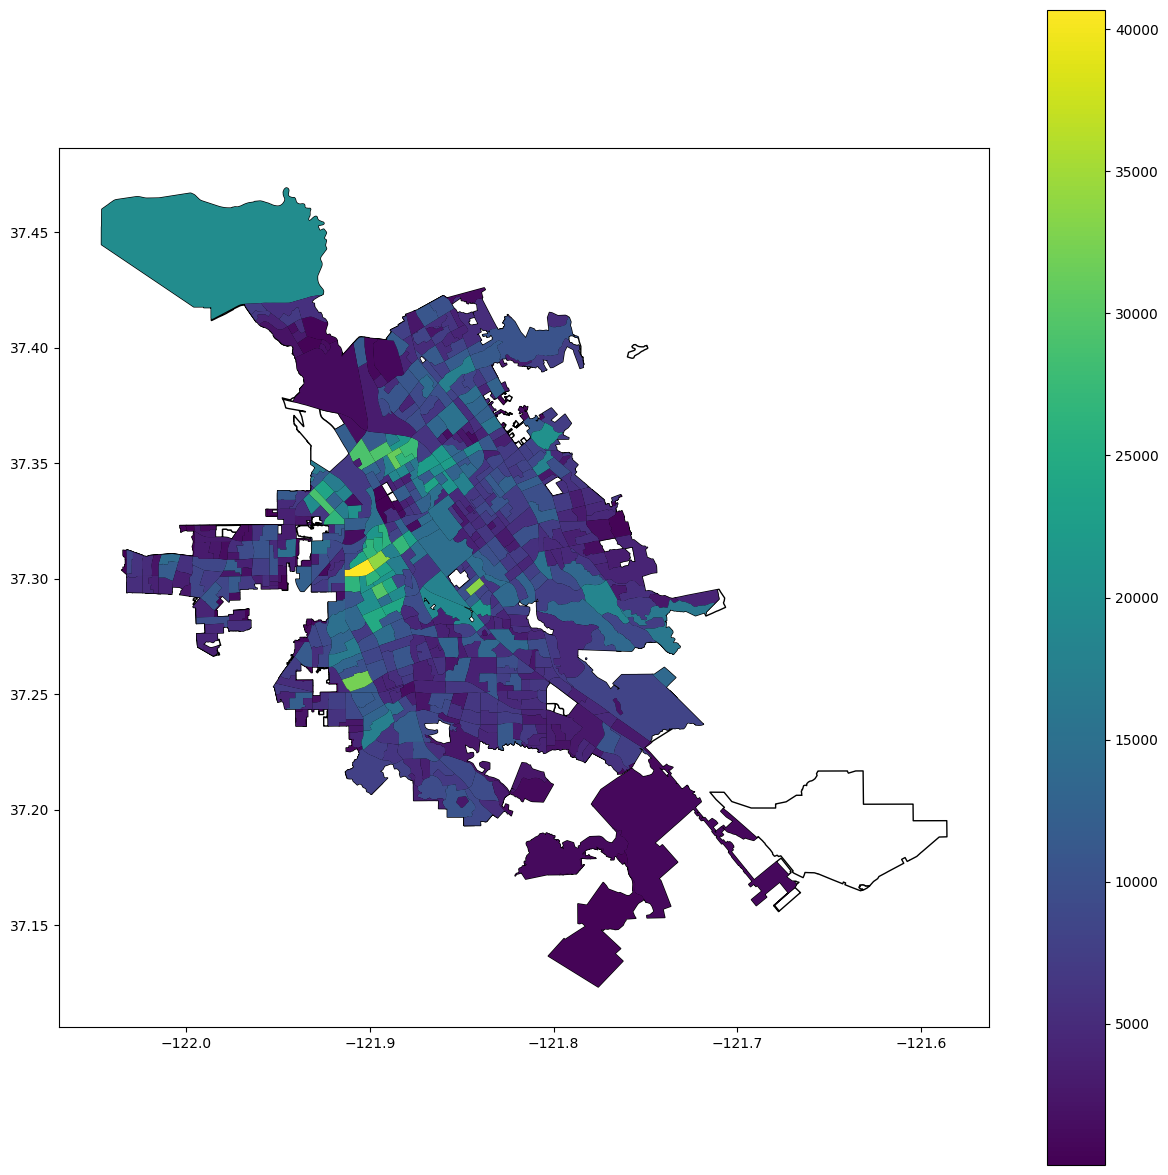

In [85]:
viz(cbg_sj, cbg_footprints, 'small', OUTPUT_FP, False)

<Figure size 640x480 with 0 Axes>

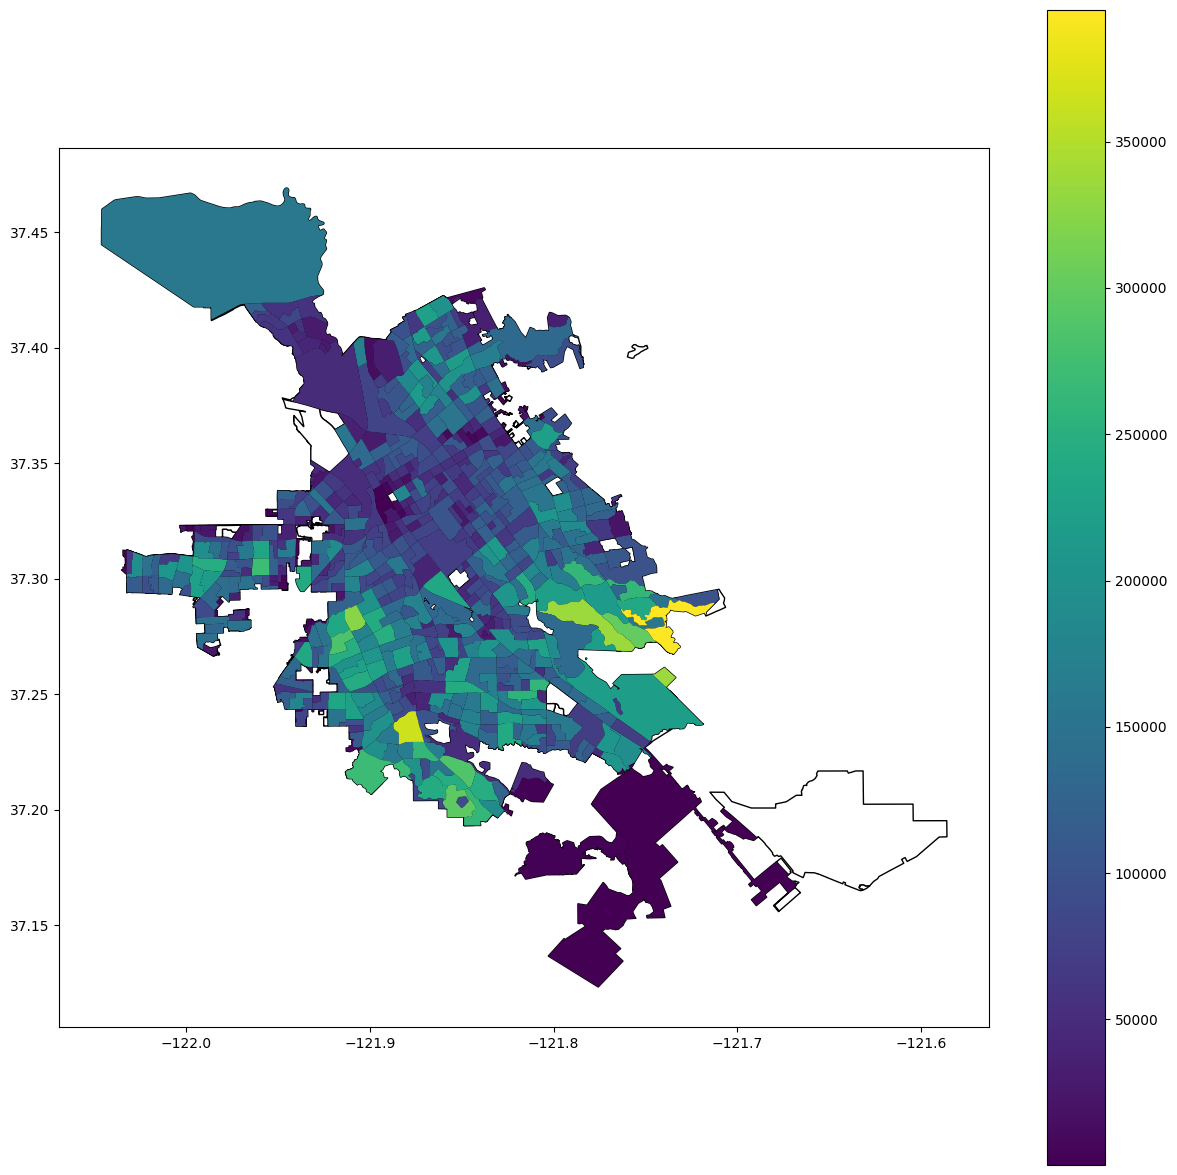

In [86]:
viz(cbg_sj, cbg_footprints, 'large', OUTPUT_FP, False)

## Debugging/checks

In [87]:
cbg_footprints.head()

,GEOID,small,large,area,geometry
0,060855001001,0,1.0,29012.906694,"POLYGON ((-121.90449 37.36091, -121.90437 37.3..."
1,060855001001,1,0.0,11493.801955,"POLYGON ((-121.90449 37.36091, -121.90437 37.3..."
2,060855001002,0,1.0,85797.290601,"POLYGON ((-121.89036 37.36277, -121.88871 37.3..."
3,060855001002,1,0.0,17000.444869,"POLYGON ((-121.89036 37.36277, -121.88871 37.3..."
4,060855001003,0,1.0,112245.475880,"POLYGON ((-121.88916 37.35724, -121.88859 37.3..."


Check

In [94]:
fp = OUTPUT_FP
collected_footprints_file = os.path.join(fp, 'building_inferences')
building_footprints = gpd.read_file(collected_footprints_file)

In [95]:
building_footprints = assign_cbgs(building_footprints, cbg_sj)

In [96]:
#geoid = '060855079061'
geoid = cbg_sj.GEOID.unique()[507]

In [97]:
len(building_footprints.GEOID.unique())

619

In [125]:
building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == geoid]

In [120]:
print(len(building_footprints_cbg))

1


In [121]:
building_footprints_cbg

,index_left,GEOID,tile,geometry
64843,15333.0,060855057004,/oak/stanford/groups/deho/building_compliance/...,"POLYGON ((-13574775.692 4486333.683, -13574774..."


In [103]:
cbg_file = os.path.join(fp, 'building_cbg_{}'.format(geoid))
cbg_geom = cbg_sj.loc[cbg_sj.GEOID == geoid].iloc[0]['geometry']

In [126]:
building_footprints_cbg = process_buildings(building_footprints_cbg, zoning_cbg, cbg_sj.crs, False)

/usr/local/lib/python3.8/dist-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/usr/local/lib/python3.8/dist-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


In [128]:
# Compute area
building_footprints_cbg = compute_area(
    building_footprints_cbg, 180, None, cbg_sj.crs)



In [61]:
# Still have footprints in individual CBG file
building_footprints_cbg_saved = gpd.read_file(os.path.join(fp, 'building_cbg_{}'.format(geoid)))

In [62]:
print(len(building_footprints_cbg_saved))

460


<Figure size 640x480 with 0 Axes>

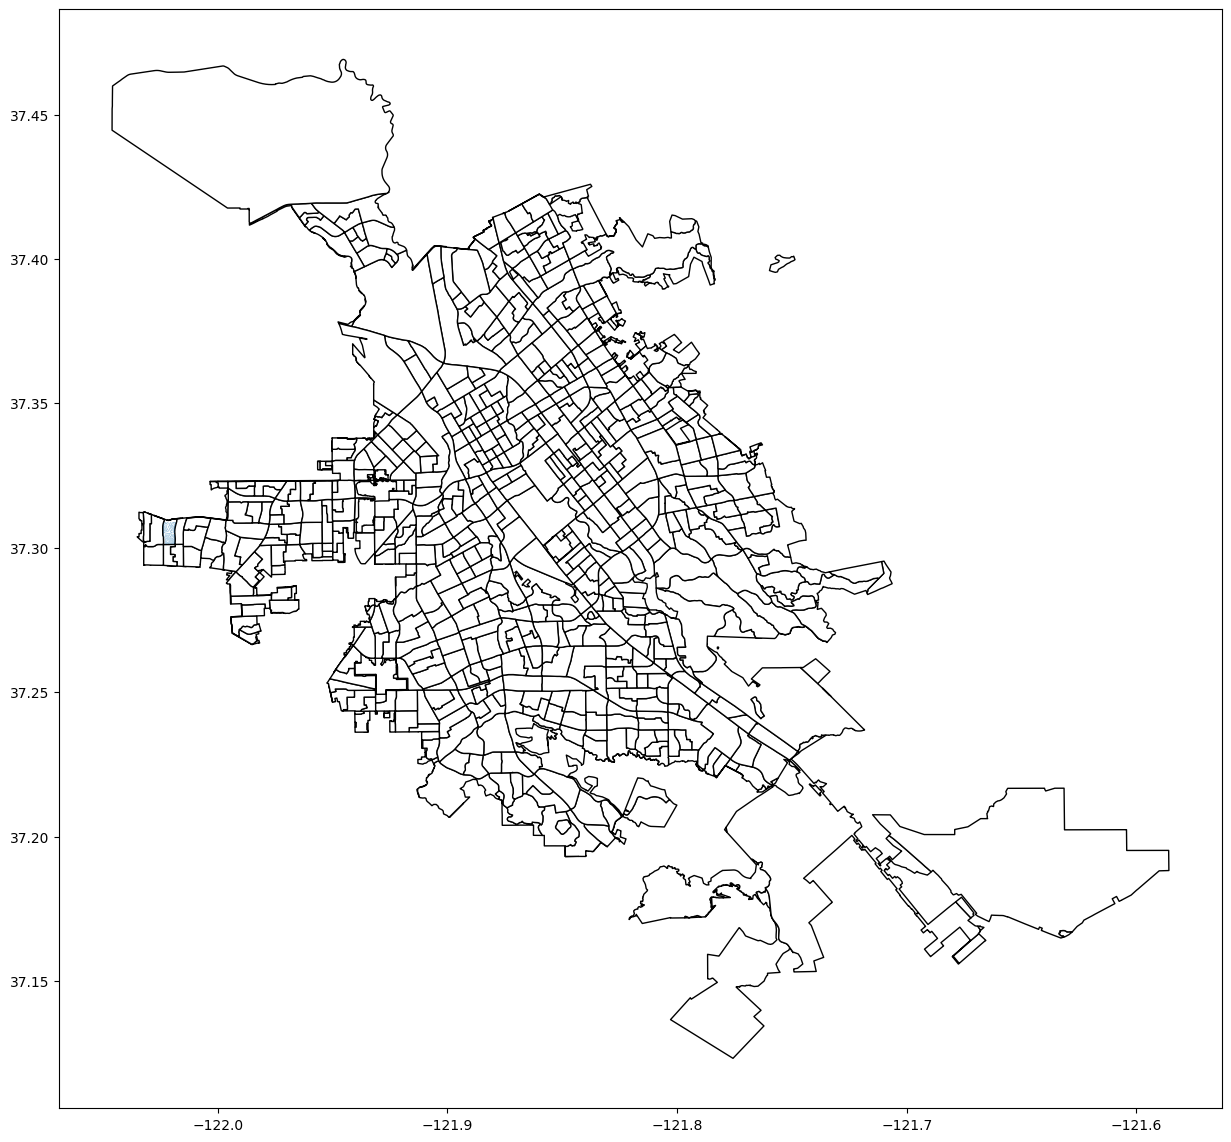

In [66]:
plt.clf()
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
ax.set_aspect('equal')
cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.loc[cbg_sj.GEOID == geoid].plot(ax=ax, zorder=2, color='green', edgecolor="black")
building_footprints_cbg_saved.plot(ax=ax, zorder=3, alpha=1)
plt.show()

In [88]:
# Footprints for the CBG do not appear in the final gdf 
building_footprints_final = gpd.read_file(os.path.join(fp, 'building_footprints_final'))

In [89]:
len(building_footprints_final.GEOID.unique())

618

In [90]:
building_footprints_final.head()

,area,small,large,GEOID,geometry
0,23.421297,1,0.0,060855122001,"POLYGON ((-121.76133 37.15183, -121.76133 37.1..."
1,32.308453,1,0.0,060855122001,"POLYGON ((-121.76122 37.15180, -121.76122 37.1..."
2,17.845765,1,0.0,060855122001,"POLYGON ((-121.76117 37.15177, -121.76117 37.1..."
3,25.538664,1,0.0,060855122001,"POLYGON ((-121.75529 37.16006, -121.75529 37.1..."
4,84.504147,1,0.0,060855122001,"POLYGON ((-121.75406 37.16017, -121.75406 37.1..."


In [91]:
building_footprints_final.loc[building_footprints_final['GEOID'] == geoid]

,area,small,large,GEOID,geometry
248397,305.153555,0,1.0,060855079061,"POLYGON ((-122.01896 37.30152, -122.01896 37.3..."
248398,398.357993,0,1.0,060855079061,"POLYGON ((-122.01893 37.30168, -122.01894 37.3..."
248399,317.309157,0,1.0,060855079061,"POLYGON ((-122.01909 37.30225, -122.01909 37.3..."
248400,359.518788,0,1.0,060855079061,"POLYGON ((-122.01890 37.30226, -122.01890 37.3..."
248401,399.590077,0,1.0,060855079061,"POLYGON ((-122.01906 37.30250, -122.01906 37.3..."
...,...,...,...,...,...
248852,350.546259,0,1.0,060855079061,"POLYGON ((-122.02219 37.30668, -122.02219 37.3..."
248853,503.874289,0,1.0,060855079061,"POLYGON ((-122.02310 37.30673, -122.02310 37.3..."
248854,331.938719,0,1.0,060855079061,"POLYGON ((-122.02128 37.30675, -122.02128 37.3..."
248855,377.401482,0,1.0,060855079061,"POLYGON ((-122.02283 37.30673, -122.02283 37.3..."


In [92]:
len(building_footprints_final)

252341

In [ ]:
252341

In [67]:
# Does not appear in CBG file
cbg_footprints = gpd.read_file(os.path.join(fp, 'cbg_inferences'))

In [68]:
cbg_footprints.loc[cbg_footprints['GEOID'] == geoid]

,GEOID,small,large,area,geometry


Visualize raw building footprints

In [ ]:
cbg = cbg_sj.GEOID.unique()[1]
building_footprints_cbg = building_footprints.loc[building_footprints['GEOID'] == cbg]

In [ ]:
plt.clf()
fig = plt.figure(figsize=(15, 15))
ax = fig.gca()
ax.set_aspect('equal')
cbg_sj.plot(ax=ax, zorder=1, color='white', edgecolor="black")
#cbg_sj.loc[cbg_sj.GEOID == cbg].plot(ax=ax, zorder=2, color='green', edgecolor="black")
building_footprints.plot(ax=ax, zorder=3, alpha=0.5)
plt.show()